In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import os

# 1.1 Baseline Setup


#### 1. Configurations


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 5
learning_rate = 0.001

#### 2. CIFAR-10 Dataset


In [3]:
transform = transforms.Compose([
    transforms.Resize(224),   # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes


100%|██████████| 170M/170M [00:05<00:00, 31.3MB/s]


#### 3. Load Pre-trained ResNet-152 + Loss and Optimizer


In [ ]:
model = models.resnet152(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # CIFAR-10 has 10 classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

#### 4. Training Loop


In [ ]:
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch [1/5], Train Acc: 83.10%, Val Acc: 82.72%
Epoch [2/5], Train Acc: 83.29%, Val Acc: 84.23%
Epoch [3/5], Train Acc: 83.66%, Val Acc: 84.97%
Epoch [4/5], Train Acc: 83.75%, Val Acc: 85.23%
Epoch [5/5], Train Acc: 84.14%, Val Acc: 83.81%


#### 5. Plot Results


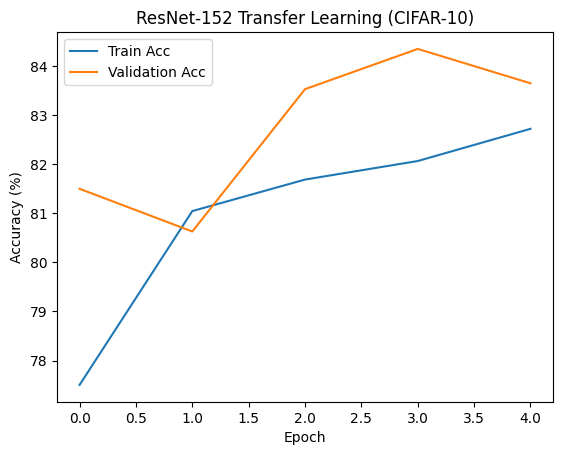

In [ ]:
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('ResNet-152 Transfer Learning (CIFAR-10)')
plt.show()

# 1.2: Residual Connections in Practice.

In [ ]:


# Patch forward() to disable skip connections
def forward_no_skip(self, x):
      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out)
      out = self.bn2(out)
      out = self.relu(out)

      out = self.conv3(out)
      out = self.bn3(out)

      # no residual addition
      out = self.relu(out)
      return out

def remove_skip_connections(model, layers_to_modify=[2, 3]):
      """
      Monkey-patch Bottleneck blocks in given layers to remove skip connections.
      layers_to_modify: [0]=layer1, [1]=layer2, [2]=layer3, [3]=layer4
      """
      layers = [model.layer1, model.layer2, model.layer3, model.layer4]
      for idx in layers_to_modify:
          layer = layers[idx]
          for block in layer:
              block.forward = forward_no_skip.__get__(block, block.__class__)
      return model



In [ ]:
from torchvision.models import resnet152, ResNet152_Weights

# Use new weights API
model = resnet152(weights=ResNet152_Weights.DEFAULT)

# Remove skips from shallow layers
model = remove_skip_connections(model, layers_to_modify=[0, 1])

# Freeze everything
for param in model.parameters():
    param.requires_grad = False

# Unfreeze modified layers so they can adapt
for param in model.layer1.parameters():
    param.requires_grad = True
for param in model.layer2.parameters():
    param.requires_grad = True

# Replace FC head
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)


In [ ]:
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total = 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch [1/5], Train Acc: 12.18%, Val Acc: 13.45%
Epoch [2/5], Train Acc: 13.34%, Val Acc: 13.01%
Epoch [3/5], Train Acc: 13.39%, Val Acc: 13.38%
Epoch [4/5], Train Acc: 13.35%, Val Acc: 14.01%
Epoch [5/5], Train Acc: 13.22%, Val Acc: 14.05%


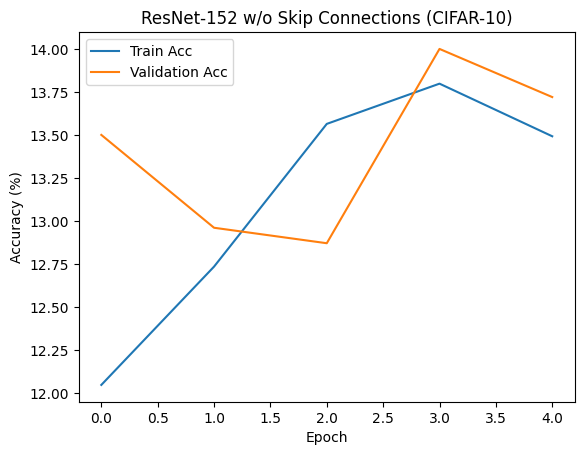

In [ ]:
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('ResNet-152 w/o Skip Connections (CIFAR-10)')
plt.show()

# 1.3 - Feature hierarchies: extract features from early/mid/late layers and visualize with UMAP/t-SNE


In [ ]:
import random
import os
import umap
import numpy as np
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet152, ResNet152_Weights
try:
    import umap
    HAS_UMAP = True
except Exception:
    from sklearn.manifold import TSNE
    print("No UMAP Lib")
    HAS_UMAP = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
MAX_SAMPLES = 1000   # how many images to collect features from (speed vs quality)
SAVE_DIR = "results/1.3"
os.makedirs(SAVE_DIR, exist_ok=True)
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),  # use ImageNet stats for pretrained models
                         (0.229, 0.224, 0.225))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# optionally use a random subset for speed
indices = list(range(len(dataset)))
random.shuffle(indices)
indices = indices[:MAX_SAMPLES]
subset = Subset(dataset, indices)
loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
model = resnet152(weights=ResNet152_Weights.DEFAULT)
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# We'll capture outputs (feature maps) from layer1, layer2, layer3, and the pre-pool penultimate representation
features = {"layer1": [], "layer2": [], "layer3": [], "avgpool": []}
torch.cuda.empty_cache()
labels_list = []

def make_hook(name):
    def hook(module, input, output):
        # output shape: (B, C, H, W) for conv blocks; for avgpool it's (B, C, 1, 1)
        features[name].append(output.detach().cpu())
    return hook

# register hooks
model.layer1.register_forward_hook(make_hook("layer1"))
model.layer2.register_forward_hook(make_hook("layer2"))
model.layer3.register_forward_hook(make_hook("layer3"))
# capture the tensor just before the final fc (after avgpool)
model.avgpool.register_forward_hook(make_hook("avgpool"))

# -----------------------------
# Run forward passes and collect features
# -----------------------------
with torch.no_grad():
    for imgs, labs in loader:
        imgs = imgs.to(device, non_blocking=True)
        _ = model(imgs)   # hooks populate `features`
        labels_list.append(labs)

# concat and process features
labels = torch.cat(labels_list).numpy()  # shape (N,)

def pool_and_flatten(tensor_list):
    t = torch.cat(tensor_list, dim=0)  # (N, C, H, W)
    if t.dim() == 4:
        t = t.mean(dim=[2,3])  # global average pool
    return t.numpy()


feat_layer1 = pool_and_flatten(features["layer1"])   # early features
feat_layer2 = pool_and_flatten(features["layer2"])   # mid features
feat_layer3 = pool_and_flatten(features["layer3"])   # late features (before avgpool)
feat_penult = pool_and_flatten(features["avgpool"])  # penultimate pooled features

print("Collected features shapes:", feat_layer1.shape, feat_layer2.shape, feat_layer3.shape, feat_penult.shape)
# note: feat_penult should be (N, 2048) typically

Collected features shapes: (1000, 256) (1000, 512) (1000, 1024) (1000, 2048)


In [ ]:
# -----------------------------
# Dimensionality reduction and plotting
# -----------------------------
def embed_and_plot(X, labels, title, fname):
    """
    X: numpy array (N, D)
    labels: numpy array (N,)
    """
    if HAS_UMAP:
        reducer = umap.UMAP(n_components=2, random_state=42)
        Z = reducer.fit_transform(X)
    else:
        tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca')
        Z = tsne.fit_transform(X)

    plt.figure(figsize=(6,6))
    num_classes = len(np.unique(labels))
    cmap = plt.get_cmap('tab10')
    for c in range(num_classes):
        idx = labels == c
        plt.scatter(Z[idx,0], Z[idx,1], s=6, label=str(c), alpha=0.7, color=cmap(c))
    plt.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.title(title)
    plt.tight_layout()
    outpath = os.path.join(SAVE_DIR, fname)
    plt.savefig(outpath, dpi=150)
    plt.close()
    print("Saved:", outpath)

# run on a few layers
embed_and_plot(feat_layer1, labels, "ResNet layer1 features (GAP -> 2D)", "layer1_umap.png")
embed_and_plot(feat_layer2, labels, "ResNet layer2 features (GAP -> 2D)", "layer2_umap.png")
embed_and_plot(feat_layer3, labels, "ResNet layer3 features (GAP -> 2D)", "layer3_umap.png")
embed_and_plot(feat_penult, labels, "ResNet penultimate features (avgpool -> 2D)", "penult_umap.png")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: results/1.3/layer1_umap.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: results/1.3/layer2_umap.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: results/1.3/layer3_umap.png


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Saved: results/1.3/penult_umap.png



# 1.4



In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet152, ResNet152_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.Resize(224), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

In [7]:
def train_model(model, optimizer, criterion, num_epochs=5, name="experiment"):
    train_acc_hist, val_acc_hist = [], []
    for epoch in range(num_epochs):
        model.train()
        correct, total = 0, 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        train_acc_hist.append(train_acc)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        val_acc_hist.append(val_acc)

        print(f"[{name}] Epoch [{epoch+1}/{num_epochs}], "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return train_acc_hist, val_acc_hist

## Experiment 1: Pretrained only

In [8]:
# Pretrained, only classification head
model = resnet152(weights=ResNet152_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

train_model(model, optimizer, criterion, num_epochs=5, name="Pretrained_FC")


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


100%|██████████| 230M/230M [00:01<00:00, 143MB/s]


[Pretrained_FC] Epoch [1/5], Train Acc: 78.61%, Val Acc: 83.31%
[Pretrained_FC] Epoch [2/5], Train Acc: 83.63%, Val Acc: 84.03%
[Pretrained_FC] Epoch [3/5], Train Acc: 84.96%, Val Acc: 85.08%
[Pretrained_FC] Epoch [4/5], Train Acc: 85.57%, Val Acc: 84.77%
[Pretrained_FC] Epoch [5/5], Train Acc: 85.94%, Val Acc: 84.66%


([78.606, 83.632, 84.96, 85.572, 85.942], [83.31, 84.03, 85.08, 84.77, 84.66])

## Experiment 2: Random initialisation

In [ ]:
# Random initialization
model = resnet152(weights=None)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_model(model, optimizer, criterion, num_epochs=5, name="Scratch")


[Scratch] Epoch [1/5], Train Acc: 38.52%, Val Acc: 48.49%
[Scratch] Epoch [2/5], Train Acc: 58.11%, Val Acc: 60.56%


## Pretrained, last block + FC fine-tuned

In [ ]:
# Pretrained, fine-tune last block (layer4) + FC
model = resnet152(weights=ResNet152_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():  # unfreeze last block
    param.requires_grad = True

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005)

train_model(model, optimizer, criterion, num_epochs=5, name="Pretrained_Layer4")
